In [1]:
# Restart the session afther this cell to avoid Google Colab errors
!pip install --upgrade --force-reinstall numpy==1.26.4 pandas

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstal

In [2]:
!pip install pybibx
!pip install tabulate tqdm

In [3]:
# Dowload .bib file
#!wget https://github.com/Valdecy/pyBibX/raw/main/assets/bibs/scopus.bib

In [4]:
# Required Libraries
import textwrap

from pybibx.base import pbx_probe
from tabulate import tabulate

/home/jefferson/paper_mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load .bib
# Arguments: file_bib = 'filename.bib'; db = 'scopus', 'wos', 'pubmed'; del_duplicated = True, False
file_name = 'dados/scopus.bib'
database  = 'scopus'
bibfile   = pbx_probe(file_bib = file_name, db = database, del_duplicated = True)

A Total of 14421 Documents were Found ( 14587 Documents and 166 Duplicates )

Article = 7785
Book = 99
Book chapter = 484
Conference paper = 4838
Conference review = 242
Data paper = 5
Editorial = 37
Erratum = 3
Note = 57
Retracted = 13
Review = 840
Short survey = 18


In [6]:
print(bibfile.data.document_type.value_counts())
filtro = ['Article','Conference paper']
bibfile.data = bibfile.data[bibfile.data['document_type'].isin(filtro)]
print(bibfile.data.document_type.value_counts())

document_type
Article              7785
Conference paper     4838
Review                840
Book chapter          484
Conference review     242
Book                   99
Note                   57
Editorial              37
Short survey           18
Retracted              13
Data paper              5
Erratum                 3
Name: count, dtype: int64
document_type
Article             7785
Conference paper    4838
Name: count, dtype: int64


In [7]:
file_name_acm = 'dados/acm.bib'
database_acm  = 'acm'
bibfile_acm   = pbx_probe(file_bib = file_name_acm, db = database_acm, del_duplicated = True)


A Total of 983 Documents were Found ( 1000 Documents and 17 Duplicates )

UNKNOWN = 983


In [8]:
bibfile.merge_database(file_bib=file_name_acm, db=database_acm, del_duplicated=True)

############################################################################

Original Database

A Total of 14421 Documents were Found ( 14587 Documents and 166 Duplicates )

Article = 7785
Book = 99
Book chapter = 484
Conference paper = 4838
Conference review = 242
Data paper = 5
Editorial = 37
Erratum = 3
Note = 57
Retracted = 13
Review = 840
Short survey = 18

############################################################################

Added Database

A Total of 983 Documents were Found ( 1000 Documents and 17 Duplicates )

UNKNOWN = 983

############################################################################

Merging Information:

A Total of 13595 Documents were Found ( 972 New Documents from the Added Database )

Article  =  7785
Conference paper  =  4838
UNKNOWN  =  972

############################################################################


In [9]:
# Health Analysis
health = bibfile.health_bib()

# Check Health
health

,Entries,Completeness (%),Number of Docs
0,Sources,92.75%,12610
1,Abstracts,98.93%,13449
2,Affiliation,92.85%,12623
3,Author(s),99.40%,13514
4,DOI,86.87%,11810
5,Keywords - Authors,77.62%,10553
6,Keywords - Plus,81.13%,11030
7,References,0.00%,0
8,Year,100.00%,13595


In [10]:
print(bibfile.data['abstract'].head(2))

0    Electric vehicles (EVs) rely heavily on lithiu...
1    Technology integration in education holds prom...
Name: abstract, dtype: object


In [11]:
print(bibfile.data.columns)

Index(['abbrev_source_title', 'abstract', 'address', 'affiliation',
       'affiliations', 'art_number', 'author', 'author_keywords',
       'chemicals_cas', 'coden', 'correspondence_address',
       'correspondence_address1', 'document_type', 'doi', 'editor',
       'funding_details', 'funding_text 1', 'funding_text 2', 'funding_text 3',
       'isbn', 'issn', 'journal', 'keywords', 'language', 'note', 'number',
       'page_count', 'pages', 'pmid', 'publication_stage', 'publisher',
       'pubmed_id', 'references', 'source', 'sponsors', 'title', 'tradenames',
       'url', 'volume', 'year', 'articleno', 'booktitle', 'issue_date',
       'location', 'month', 'numpages', 'series'],
      dtype='object')


In [12]:
!pip install pybtex
!pip install bibtexparser

In [13]:
import pandas as pd
import bibtexparser
from bibtexparser.bwriter import BibTexWriter
from bibtexparser.bibdatabase import BibDatabase


In [14]:
import time
import os
import random
from multiprocessing import Pool, cpu_count
from functools import partial
import pandas as pd
import ollama

# === CONFIGURAÇÕES GLOBAIS ===
MAX_REQUESTS_PER_MINUTE = 300
SECONDS_BETWEEN_REQUESTS = 60 / MAX_REQUESTS_PER_MINUTE
BATCH_SIZE = 1
WORKERS = min(8, cpu_count())
MODELS = ["llama3:8b", "gemma3:27b-it-qat", "phi4-mini", "phi4"]
TEMPERATURE = 0

QUERY = (
    #"Does this abstract discuss artificial intelligence in feedback for learning management systems or online learning environment on education?"
    "Analyze the following scientific article abstract and determine whether it "
     "addresses the use of artificial intelligence to provide feedback in virtual learning environments.\n"
     "Consider aspects such as: the application of AI techniques, automated feedback systems, "
     "digital educational platforms, and online learning. Respond only with ‘yes’ if the article is related, "
     "or ‘no’ if it is not.\n\n"
)

# === UTILITÁRIOS ===
def log(text: str, log_path: str) -> None:
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(f"{timestamp} - {text}\n")
    print(f"{timestamp} - {text}")


def chunk_dataframe(df, batch_size: int):
    for i in range(0, len(df), batch_size):
        yield df.iloc[i : i + batch_size], i


# === CHAMADA AO LLM LOCAL ===
def call_local_llm(messages, model: str, temperature: float):
    response = ollama.chat(
        model=model,
        messages=messages,
        options={"temperature": temperature},
        stream=False
    )
    return response.message.content.strip()


# === PROCESSAMENTO DE LOTE COM RETRIES ===
def process_batch_with_retry(
    batch_df, global_index, query, model, temperature,
    seconds_between_requests, log_path, retry_limit=5
):
    retry_count = 0
    delay = seconds_between_requests + random.uniform(0, 5)

    while retry_count < retry_limit:
        try:
            if model == "cogito:8b":
                time.sleep(delay)
                messages = [
                    {"role": "system", "content": (
                        "Enable deep thinking subroutine."
                    )}
                ]
                prompt = f"{query}\n\nYou are a research assistant who helps analyze scientific articles. Restrict yourself to answering the question with exclusively 'yes' or 'no'.\n\n"
            else:
                time.sleep(delay)
                messages = [
                    {"role": "system", "content": (
                        "You are a research assistant who helps analyze scientific articles."
                    )}
                ]
                prompt = f"{query}\n\nRestrict yourself to answering the question with exclusively 'yes' or 'no'.\n\n"

            for i, row in batch_df.iterrows():
                prompt += f"Abstract {i + 1}:\n{row['abstract']}\n\n"

            messages.append({"role": "user", "content": prompt})

            content = call_local_llm(messages, model=model, temperature=temperature)
            answers = content.splitlines()

            results = []
            coluna = "relevant_" + model.split(":")[0]
            for answer, (_, row) in zip(answers, batch_df.iterrows()):
                result = row.to_dict()
                clean = answer.strip().lower()
                result[coluna] = (clean == "yes")
                results.append(result)

            log(f"[{model}] Lote {global_index} OK", log_path)
            return results

        except Exception as e:
            retry_count += 1
            wait_time = 2 ** retry_count + random.uniform(0, 1)
            log(f"[{model}][ERRO] Lote {global_index}, tentativa {retry_count}: {e}", log_path)
            time.sleep(wait_time)

    log(f"[{model}][FALHA] Lote {global_index} excedeu tentativas", log_path)
    return []


def process_args_wrapper(args, query, model, temperature, seconds_between_requests, log_path):
    return process_batch_with_retry(*args, query=query, model=model,
                                    temperature=temperature,
                                    seconds_between_requests=seconds_between_requests,
                                    log_path=log_path)


# === PIPELINE PARA UM MODELO ===
def analyze_abstracts_parallel(
    df: pd.DataFrame,
    query: str,
    model: str,
    batch_size: int,
    workers: int,
    result_csv_path: str,
    log_path: str,
    temperature: float,
    seconds_between_requests: float,
) -> pd.DataFrame:
    if os.path.exists(result_csv_path):
        acumulado = pd.read_csv(result_csv_path)
        start = len(acumulado)
        log(f"[{model}] Retomando do índice {start}", log_path)
    else:
        acumulado = pd.DataFrame()
        start = 0

    to_process = df.iloc[start:].reset_index(drop=True)
    batches = [
        (batch, idx + start)
        for batch, idx in chunk_dataframe(to_process, batch_size)
    ]

    log(f"[{model}] Iniciando {len(batches)} lotes com {workers} workers", log_path)

    with Pool(processes=workers) as pool:
        processor = partial(
            process_args_wrapper,
            query=query,
            model=model,
            temperature=temperature,
            seconds_between_requests=seconds_between_requests,
            log_path=log_path
        )
        for outcome in pool.imap_unordered(processor, batches):
            if outcome:
                df_part = pd.DataFrame(outcome)
                acumulado = pd.concat([acumulado, df_part], ignore_index=True)
                acumulado.to_csv(result_csv_path, index=False)

    log(f"[{model}] Processamento completo.", log_path)
    return acumulado


# === RUN_ALL_MODELS MODIFICADA ===
def run_all_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Executa o pipeline para todos os modelos em MODELS e retorna um DataFrame combinado
    contendo todas as colunas relevant_<model>.
    """
    combined = df.copy()

    for model in MODELS:
        model_name = model.split(":")[0]
        result_path = f"temp_files/resultados_parciais_{model_name}.csv"
        log_path = f"temp_files/log_execucao_{model_name}.txt"

                # ajusta workers para alguns modelos (exemplo)
        extra = 0
        if model in ("gemma3:27b-it-qat","phi4-mini"): extra = 4
        workers = WORKERS + extra

        resultados = analyze_abstracts_parallel(
            df=combined,
            query=QUERY,
            model=model,
            batch_size=BATCH_SIZE,
            workers=workers,
            result_csv_path=result_path,
            log_path=log_path,
            temperature=TEMPERATURE,
            seconds_between_requests=SECONDS_BETWEEN_REQUESTS
        )

        col = f"relevant_{model_name}"
        combined = combined.merge(
            resultados[[col]],
            left_index=True, right_index=True
        )

    return combined


In [15]:
def load_and_filter_bases(directory: str) -> pd.DataFrame:
    print(f"Carregando bases de '{directory}'")
    dfs = []
    for fname in sorted(os.listdir(directory)):
        if fname.lower().endswith('.csv'):
            path = os.path.join(directory, fname)
            try:
                df = pd.read_csv(path)
                print(f"{fname}: {len(df)} registros")
                dfs.append(df)
            except Exception as e:
                print(f"Erro lendo {fname}: {e}")
    if not dfs:
        return pd.DataFrame()
    df = pd.concat(dfs, ignore_index=True)
    return df


In [16]:
dados = bibfile.data
df_ieee = load_and_filter_bases("dados")
colunas_desejadas_ieee = ['Document Title', 'Abstract', 'Author Affiliations', 'Authors', 'DOI', 'ISBNs',
                             'ISSN', 'Publication Title', 'Publication Year']
df_ieee = df_ieee[colunas_desejadas_ieee].copy()
#print(df_ieee.columns)
colunas_desejadas_scopus = ['title', 'abstract', 'journal', 
                            'affiliation', 'author', 'doi', 'isbn',
                             'issn', 'year']

df_scopus = dados[colunas_desejadas_scopus].copy()
df_scopus = df_scopus.rename(columns={
    'title': 'Document Title',
    'abstract': 'Abstract',
    'abbrev_source_title': 'Publication Title',
    'affiliation': 'Author Affiliations',
    'author': 'Authors',
    'doi': 'DOI',
    'isbn': 'ISBNs',
    'issn': 'ISSN',
    'journal': 'Publication Title',
    'references': 'References',
    'url': 'URL',
    'year': 'Publication Year'
})


# Certifique-se de que o DataFrame `dados` contém pelo menos as colunas 'abstract' e outras desejadas
#resultados = analyze_abstracts_parallel(dados, query=query_global, model=model, batch_size=5, workers=8)

print(df_ieee.shape, '\t', df_scopus.shape)
dados = pd.concat([df_ieee, df_scopus], ignore_index=True)
print('Antes da remoção de duplicados: ', dados.shape)
dados.columns = dados.columns.str.lower()
dados = dados.dropna(subset=['abstract'])
dados = dados.drop_duplicates(subset=['abstract'])
dados = dados.reset_index(drop=True)
print('Após remoção de duplicados: ', dados.shape)

resultados = run_all_models(dados)

# Salvar CSV final (opcional)
resultados.to_csv("temp_files/resultados_finais.csv", index=False)

Carregando bases de 'dados'
export_ieee_2015-2018.csv: 799 registros
export_ieee_2018-2022.csv: 695 registros
export_ieee_2022-2025.csv: 936 registros
(2430, 9) 	 (13595, 9)
Antes da remoção de duplicados:  (16025, 9)
Após remoção de duplicados:  (15614, 9)
2025-04-23 13:06:21 - [llama3:8b] Retomando do índice 15614
2025-04-23 13:06:21 - [llama3:8b] Iniciando 0 lotes com 8 workers
2025-04-23 13:06:21 - [llama3:8b] Processamento completo.
2025-04-23 13:06:22 - [gemma3:27b-it-qat] Retomando do índice 15614
2025-04-23 13:06:22 - [gemma3:27b-it-qat] Iniciando 0 lotes com 12 workers
2025-04-23 13:06:22 - [gemma3:27b-it-qat] Processamento completo.
2025-04-23 13:06:22 - [phi4-mini] Retomando do índice 15494
2025-04-23 13:06:22 - [phi4-mini] Iniciando 120 lotes com 12 workers
2025-04-23 13:06:25 - [phi4-mini] Lote 15494 OK
2025-04-23 13:06:25 - [phi4-mini] Lote 15496 OK2025-04-23 13:06:25 - [phi4-mini] Lote 15498 OK2025-04-23 13:06:25 - [phi4-mini] Lote 15503 OK


2025-04-23 13:06:25 - [phi4-

In [17]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [18]:
print(resultados.columns)
# Exibir os resultados
for model in MODELS:
    model_name = model.split(":")[0]
    print(f"\nResultados para o modelo {model_name}:")
    print(resultados[f'relevant_{model_name}'].value_counts())
#dados_filtered = resultados[resultados['relevant'] != 'False']
#dados_filtered.head(3)

Index(['document title', 'abstract', 'author affiliations', 'authors', 'doi',
       'isbns', 'issn', 'publication title', 'publication year',
       'relevant_llama3', 'relevant_gemma3', 'relevant_phi4-mini',
       'relevant_phi4'],
      dtype='object')

Resultados para o modelo llama3:
relevant_llama3
False    14092
True      1522
Name: count, dtype: int64

Resultados para o modelo gemma3:
relevant_gemma3
False    13283
True      2331
Name: count, dtype: int64

Resultados para o modelo phi4-mini:
relevant_phi4-mini
False    13426
True      2188
Name: count, dtype: int64

Resultados para o modelo phi4:
relevant_phi4
False    15127
True       487
Name: count, dtype: int64


## Avaliação da diferença entre os modelos

In [19]:
def apply_committee(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adiciona ao DataFrame uma coluna 'relevant' que será 'true' se a
    maioria (≥3) das colunas ['a','b','c','d','e'] for 'true', caso
    contrário 'false'.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame contendo as colunas 'a','b','c','d' e 'e', com valores
        'true' ou 'false' (strings).

    Retorna
    -------
    pd.DataFrame
        O mesmo DataFrame, com a coluna 'relevant' adicionada.
    """
    cols = ['relevant_llama3', 'relevant_gemma3', 'relevant_phi4-mini', 'relevant_phi4']
    # Verifica se as colunas existem no DataFrame
    for col in cols:
        if col not in df.columns:
            raise ValueError(f"Coluna {col} não encontrada no DataFrame.")
    # Conta quantos 'true' por linha
    true_counts = df[cols].eq(True).sum(axis=1)
    # Define 'relevant' = 'true' se true_counts >= 3, senão 'false'
    df['relevant'] = (true_counts >= 3).map({True: True, False: False})
    return df

In [36]:
resultados_com_relevancia = apply_committee(resultados)
resultados_com_relevancia.to_csv("temp_files/resultados_finais_com_relevancia.csv", index=False)
print(resultados_com_relevancia['relevant'].value_counts())

relevant
False    15459
True       155
Name: count, dtype: int64


In [38]:
print(resultados_com_relevancia['relevant'].value_counts())
print(resultados_com_relevancia[resultados_com_relevancia['relevant'] == 'yes'])

relevant
False    15459
True       155
Name: count, dtype: int64
Empty DataFrame
Columns: [document title, abstract, author affiliations, authors, doi, isbns, issn, publication title, publication year, relevant_llama3, relevant_gemma3, relevant_phi4-mini, relevant_phi4, relevant, QE1, QE2, QE3, QE4, QE5, QE6, incluso_avaliacao]
Index: []

[0 rows x 21 columns]


## Critrérios de exclusão

1. Livro
2. Artigos resumidos
3. Revisões de literatura
4. Relatórios técnicos
5. Escrito em língua estrangeira que não seja o inglês
6. Simulou cenários


In [ ]:
# ----------------------------
# Critérios de Exclusão
# ----------------------------
criterios_exclusao: dict[str, str] = {
"QE1": "Is it a Book?",
"QE2": "Is it a Summarized articles",
"QE3": "Is it a Literature reviews",
"QE4": "Is it aTechnical reports",
"QE5": "Was it written in a language other than English",
"QE6": "Is it a Simulated scenarios"
}

In [ ]:
def verifica_criterio_llm(abstract: str, descricao: str, model: str, temperature: float) -> str:
    prompt = (
        f"The following exclusion criterion applies to the abstract below.?\n\n"
        f"Criterion: {descricao}\n\n"
        f"Abstract:\n{abstract}\n\n"
        "Answer only with 'yes' or 'no'."
    )
    # mesma função de chamada usada acima
    system_msg = {"role": "system", "content": "You are a research assistant."}
    user_msg   = {"role": "user",   "content": prompt}
    try:
        resp = call_local_llm([system_msg, user_msg], model=model, temperature=temperature)
        resp_clean = resp.strip().lower()
        return resp_clean if resp_clean in ("yes","no") else "não"
    except:
        return "no"

def apply_exclusion_criteria(
    df: pd.DataFrame,
    criterios: dict[str,str],
    model: str,
    temperature: float,
    delay: float,
    log_path: str
) -> pd.DataFrame:
    for code, desc in criterios.items():
        log(f"Iniciando verificação do {code}: {desc}", log_path)
        df[code] = df["abstract"].apply(
            lambda txt: verifica_criterio_llm(txt, desc, model, temperature)
        )
        time.sleep(delay)
    log("Verificação de todos os critérios concluída.", log_path)
    return df

In [ ]:
exclusion_log = "temp_files/log_exclusao.txt"
resultados_com_relevancia_apenas_True = resultados_com_relevancia[resultados_com_relevancia['relevant'] == True]
resultados_com_relevancia_apenas_True = resultados_com_relevancia_apenas_True.reset_index(drop=True)

papers_criterios_exclusao = apply_exclusion_criteria(
    resultados_com_relevancia_apenas_True,
    criterios_exclusao,
    model=MODELS[0],
    temperature=TEMPERATURE,
    delay=SECONDS_BETWEEN_REQUESTS,
    log_path=exclusion_log
)

papers_criterios_exclusao.to_csv("temp_files/resultados_criterios_exclusao.csv", index=False)
print("Pipeline completa! Resultados em temp_files/resultados_criterios_exclusao.csv")

2025-04-23 15:41:49 - Iniciando verificação do QE1: Livro
2025-04-23 16:03:41 - Iniciando verificação do QE2: Artigos resumidos
2025-04-23 16:25:28 - Iniciando verificação do QE3: Revisões de literatura
2025-04-23 16:46:52 - Iniciando verificação do QE4: Relatórios técnicos
2025-04-23 17:08:16 - Iniciando verificação do QE5: Escrito em língua estrangeira que não seja o inglês
2025-04-23 17:29:51 - Iniciando verificação do QE6: Simulou cenários
2025-04-23 17:49:37 - Verificação de todos os critérios concluída.
Pipeline completa! Resultados em temp_files/resultados_criterios_exclusao.csv


In [31]:
def apply_committee_criterios_exclusao(df: pd.DataFrame, criterios: dict[str, str]) -> pd.DataFrame:
    """
    Adiciona ao DataFrame uma coluna 'incluso' que será 'true' se a
    maioria (≥3) das colunas ['a','b','c','d','e'] for 'true', caso
    contrário 'false'.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame contendo as colunas , com valores
        'sim' ou 'não' (strings).

    Retorna
    -------
    pd.DataFrame
        O mesmo DataFrame, com a coluna 'incluso_avaliacao' adicionada.
    """
    cols = list(criterios.keys())
    # Verifica se as colunas existem no DataFrame
    for col in cols:
        if col not in df.columns:
            raise ValueError(f"Coluna {col} não encontrada no DataFrame.")
    # Conta quantos 'true' por linha
    true_counts = df[cols].eq("sim").sum(axis=1)
    # Define 'relevant' = 'true' se true_counts >= 3, senão 'false'
    df['incluso_avaliacao'] = (true_counts > 0).map({True: True, False: False})
    return df

In [33]:
resultados_com_criterios_aplicados = apply_committee_criterios_exclusao(papers_criterios_exclusao, criterios_exclusao)

In [35]:
print(resultados_com_criterios_aplicados[resultados_com_criterios_aplicados['incluso_avaliacao'] == True].shape)

(13441, 21)


## Critérios de inclusão

1. Forneceu feedback automatizados para os estudantes
2. Artigos primários
3. Publicado nos últimos quinze anos (abranger o “boom” da IA)
4. Estudos envolvendo aprendizes em qualquer nível educacional (fundamental, médio, superior, formação corporativa) que utilizem um AVA
5. Implementações de inteligência artificial (machine learning, NLP, agentes conversacionais, sistemas especialistas, etc.) voltadas à geração de feedback automatizado
6. Ambientes virtuais de aprendizagem (Moodle, Canvas, Blackboard, Google Classroom, Open edX, entre outros)
7. Trabalhos que relatem pelo menos um dos seguintes resultados:

    7.1. Qualidade / utilidade do feedback

    7.2. Impacto no desempenho acadêmico ou engajamento

    7.3. Satisfação dos estudantes ou docentes
    
    7.4. Métricas de eficiência do sistema (tempo, custo, escalabilidade).

8. Estudos empíricos (experimentos controlados, quase‑experimentos, estudos de caso, design‑based research) e relatos de desenvolvimento avaliados (artigos de conference/journal com validação)
9. Publicações revisadas por pares: artigos de periódicos, capítulos de livro, anais de conferências; teses e dissertações defendidas


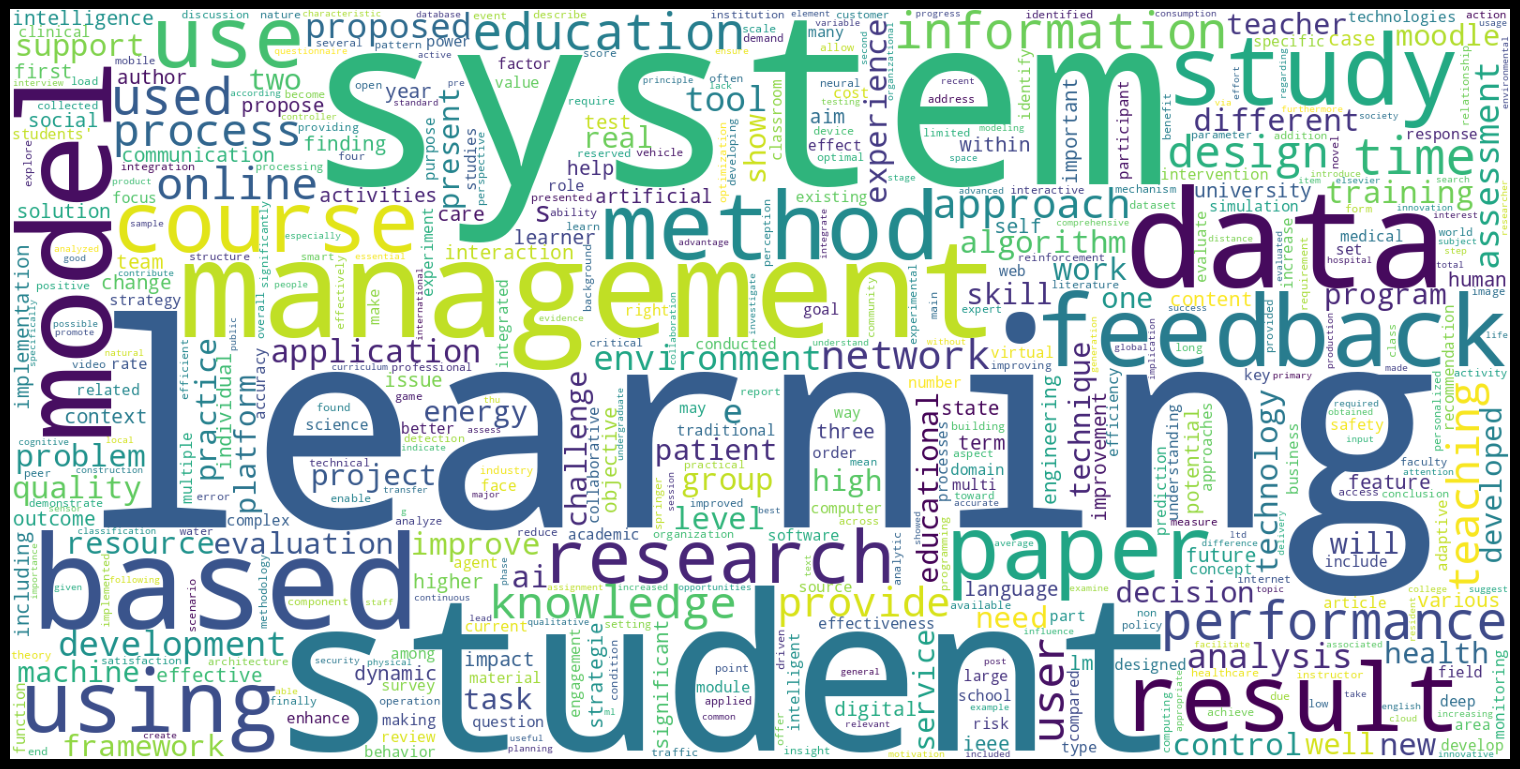

In [25]:
bibfile.data = resultados_com_relevancia.reset_index()
bibfile.data['relevant'] = bibfile.data['relevant'].astype(bool)
bibfile.data['relevant'] = bibfile.data['relevant'].replace({True: 'yes', False: 'no'})
bibfile.data['relevant'] = bibfile.data['relevant'].astype(str)
bibfile.data = bibfile.data.drop(columns=['relevant_llama3', 'relevant_gemma3', 'relevant_phi4-mini', 'relevant_phi4'])
bibfile.word_cloud_plot(entry = 'abs', size_x = 15, size_y = 10, wordsn = 500, rmv_custom_words = [])

In [26]:
if 'publication year' in bibfile.data.columns:
    bibfile.data['publication year'] = bibfile.data['publication year'].astype(str)
    bibfile.data['publication year'] = pd.to_numeric(bibfile.data['publication year'], errors='coerce')
    bibfile.data = bibfile.data.dropna(subset=['publication year'])
    bibfile.data = bibfile.data.rename(columns={'publication year': 'year'})
print(bibfile.data.columns)
bibfile.plot_evolution_year(view             = 'notebook',
                            stop_words       = ['en'],
                            rmv_custom_words = [],
                            key              = 'abs',
                            topn             = 10,
                            txt_font_size    = 12,
                            start            = 2010,
                            end              = 2025)

Index(['index', 'document title', 'abstract', 'author affiliations', 'authors',
       'doi', 'isbns', 'issn', 'publication title', 'year', 'relevant', 'QE1',
       'QE2', 'QE3', 'QE4', 'QE5', 'QE6'],
      dtype='object')


KeyError: 14715

In [ ]:
bibfile.sankey_diagram(view = 'notebook', entry = ['aut', 'cout', 'inst', 'lan'], topn = 3)

In [ ]:
bibfile.network_sim(view = 'notebook', sim_type = 'cocit', node_size = 10, node_labels = True, cut_coup = 0.3, cut_cocit = 5)